In [ ]:
#--Phase 0: Historical data scraper to build a rich dataset for analysis and modeling - scraping data as far back as 6 months.

from GoogleNews import GoogleNews
import pandas as pd
from datetime import datetime, timedelta
import time 

# defining tickers we want to scrape news for
tickers = ['AAPL', 'MSFT', 'GOOGL']
num_days_to_scrape = 180  

googlenews = GoogleNews(lang='en', region='US')
googlenews.set_encode('utf-8')
all_articles = []

print(f"Starting historical scrape for the last {num_days_to_scrape} days...")
end_date = datetime.now()

for i in range(num_days_to_scrape):
    date_to_scrape = end_date - timedelta(days=i)
    date_str = date_to_scrape.strftime('%m/%d/%Y')
    
    googlenews.set_time_range(start=date_str, end=date_str)
    
    for ticker in tickers:
        print(f"  -> Searching for {ticker} news on {date_str}...")
        googlenews.clear() # Clear previous search results
        googlenews.get_news(f'{ticker} stock finance')
        results = googlenews.results(sort=True)
        
        for res in results:
            all_articles.append({
                'ticker': ticker.upper(),
                'headline': res.get('title'),
                'summary': res.get('desc'),
                'link': res.get('link'),
                'scraped_at': res.get('datetime') or date_to_scrape
            })
        
        time.sleep(1) 

# Save to dataframe and CSV 
historical_df = pd.DataFrame(all_articles)
print(f"\nScraping complete! Found {len(historical_df)} historical articles.")

historical_df.to_csv('historical_news_data.csv', index=False)
print("Historical data saved to 'historical_news_data.csv'.")

historical_df.head()

In [ ]:
#--Phase 1: Load historical data and live data from Google Sheets, combine, deduplicate, and sort.

import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe


# Load historical data and standardize
print("Loading historical news data...")
try:
    historical_df = pd.read_csv('historical_news_data.csv')
    # Standardize columns IMMEDIATELY after loading
    historical_df.columns = historical_df.columns.str.lower().str.strip()
    print(f"Loaded {len(historical_df)} historical rows.")
except FileNotFoundError:
    print("Historical data file not found. Creating empty DataFrame.")
    historical_df = pd.DataFrame()

# Load live data from n8n automation & google sheets and standardize 
print("\n Loading live news data from Google Sheets...")
try:
    gc = gspread.service_account(filename='credentials.json')
    worksheet = gc.open("Financial News Scraper").sheet1
    live_df = get_as_dataframe(worksheet, header=0)
    # Standardize columns IMMEDIATELY after loading
    live_df.columns = live_df.columns.str.lower().str.strip()
    print(f"Loaded {len(live_df)} live rows.")
except Exception as e:
    print(f"Could not load from Google Sheet. Error: {e}. Creating empty DataFrame.")
    live_df = pd.DataFrame()

# Combine, Deduplicate, and Sort 
print("\nCombining all data...")

df = pd.concat([historical_df, live_df], ignore_index=True)

# Remove any potential duplicate headlines
if 'headline' in df.columns:
    df = df.drop_duplicates(subset=['headline'], keep='last')

# Convert scraped_at to datetime and remove any rows where conversion fails
if 'scraped_at' in df.columns:
    df['scraped_at'] = pd.to_datetime(df['scraped_at'], errors='coerce')
    df = df.dropna(subset=['scraped_at'])
    # Sort the entire dataset by date
    df = df.sort_values(by='scraped_at', ascending=False).reset_index(drop=True)

print(f"\nSuccessfully combined all data. Total unique articles: {len(df)}")
df.head()

--- Step 1.1: Loading historical news data... ---
Loaded 767 historical rows.

--- Step 1.2: Loading live news data from Google Sheets... ---
Loaded 90 live rows.

--- Step 1.3: Combining all data... ---

Successfully combined all data. Total unique articles: 735


,ticker,headline,summary,link,scraped_at
0,GOOGL,Google's market value surge - how to invest now?,NaN,https://news.google.com/read/CBMiekFVX3lxTFBOd...,2025-08-25 22:03:28.665076
1,AAPL,Apple (AAPL) Considers Using Google Gemini to ...,NaN,https://news.google.com/read/CBMijAFBVV95cUxON...,2025-08-24 22:03:31.978909
2,AAPL,Apple (AAPL) vs. Amazon (AMZN): Which Is the B...,NaN,https://news.google.com/read/CBMihwFBVV95cUxOe...,2025-08-21 22:03:59.726656
3,GOOGL,Terawulf (WULF) Cracks Past New All-Time High ...,NaN,https://news.google.com/read/CBMiggFBVV95cUxQY...,2025-08-19 22:04:23.652763
4,GOOGL,Florida is now the 2nd most financially distre...,NaN,https://news.google.com/read/CBMihAFBVV95cUxPS...,2025-08-19 22:04:23.652763


In [ ]:
# ---Phase 2: Download stock data, calculate volatility, and merge with news data

import yfinance as yf
from pandas.tseries.offsets import BDay

print("Downloading, preparing, and merging stock data...")

# Download and process the stock data from yfinance
tickers = df['ticker'].unique().tolist()
start_date = '2022-01-01'

stock_df_raw = yf.download(tickers, start=start_date, auto_adjust=True)
stock_df = stock_df_raw['Close'].stack().reset_index()
stock_df.columns = ['Date', 'ticker', 'Close']

stock_df = stock_df.sort_values(by=['ticker', 'Date'])
stock_df['daily_return'] = stock_df.groupby('ticker')['Close'].pct_change()
stock_df['volatility'] = stock_df.groupby('ticker')['daily_return'].rolling(window=7).std().reset_index(0,drop=True)

# Prepare date columns for merging
df['date'] = pd.to_datetime(df['scraped_at']).dt.date
stock_df['date'] = pd.to_datetime(stock_df['Date']).dt.date

master_df = pd.merge(stock_df, df, on=['date', 'ticker'], how='left')

master_df = master_df.dropna(subset=['Close', 'volatility'])

print(f"Merge complete. Master DataFrame created with {len(master_df)} rows.")
master_df.head()

--- Step 2: Downloading, preparing, and merging stock data... ---


[*********************100%***********************]  3 of 3 completed

Merge complete. Master DataFrame created with 3097 rows.


,Date,ticker,Close,daily_return,volatility,date,headline,summary,link,scraped_at
7,2022-01-12,AAPL,172.090118,0.002570,0.014470,2022-01-12,NaN,NaN,NaN,NaT
8,2022-01-13,AAPL,168.815567,-0.019028,0.015205,2022-01-13,NaN,NaN,NaN,NaT
9,2022-01-14,AAPL,169.678360,0.005111,0.012526,2022-01-14,NaN,NaN,NaN,NaT
10,2022-01-18,AAPL,166.472397,-0.018894,0.012992,2022-01-18,NaN,NaN,NaN,NaT
11,2022-01-19,AAPL,162.972351,-0.021025,0.014758,2022-01-19,NaN,NaN,NaN,NaT


In [ ]:
#--Phase 3: Perform sentiment analysis using FinBERT model

from transformers import pipeline
import pandas as pd

print("Performing sentiment analysis with FinBERT...")

# Data cleaning and text prep
# Use master_df as the input
master_df['headline'] = master_df['headline'].fillna('')
master_df['summary'] = master_df['summary'].fillna('')

master_df['text_for_sentiment'] = master_df['headline'] + '. ' + master_df['summary']
print("Created a combined 'text_for_sentiment' column for analysis.")


print("Loading the FinBERT sentiment analysis model...")
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

def get_sentiment_score(sentiment_result):
    if sentiment_result['label'] == 'positive':
        return sentiment_result['score']
    elif sentiment_result['label'] == 'negative':
        return -sentiment_result['score']
    else:
        return 0.0

print("\nApplying sentiment analysis to all articles... (This can take a few minutes)")

# Apply the pipeline to our new column in master_df
all_sentiments = sentiment_pipeline(master_df['text_for_sentiment'].tolist())
master_df['sentiment_score'] = [get_sentiment_score(s) for s in all_sentiments]

print("Sentiment analysis complete!")

master_df[['ticker', 'headline', 'sentiment_score']].head()

--- Step 3: Performing sentiment analysis... ---
Created a combined 'text_for_sentiment' column for analysis.
Loading the FinBERT sentiment analysis model...

Applying sentiment analysis to all articles... (This can take a few minutes)
Sentiment analysis complete!


,ticker,headline,sentiment_score
7,AAPL,,0.0
8,AAPL,,0.0
9,AAPL,,0.0
10,AAPL,,0.0
11,AAPL,,0.0


In [ ]:
#--Phase 4: Aggregate article-level sentiment to daily level and prepare final dataset

print("Aggregating article data to the daily level...")

daily_df = master_df.groupby(['date', 'ticker']).agg(
    mean_sentiment=('sentiment_score', 'mean'),
    sentiment_std=('sentiment_score', 'std'),
    news_volume=('headline', 'count'),
    Close=('Close', 'first'),
    volatility=('volatility', 'first')
).reset_index()

daily_df['sentiment_std'] = daily_df['sentiment_std'].fillna(0)

print(f"Created daily aggregated dataset with {len(daily_df)} rows.")

daily_df.head()

Aggregating article data to the daily level...
Created daily aggregated dataset with 2730 rows.


,date,ticker,mean_sentiment,sentiment_std,news_volume,Close,volatility
0,2022-01-12,AAPL,0.0,0.0,1,172.090118,0.014470
1,2022-01-12,GOOGL,0.0,0.0,1,140.587341,0.020090
2,2022-01-12,MSFT,0.0,0.0,1,308.528961,0.016305
3,2022-01-13,AAPL,0.0,0.0,1,168.815567,0.015205
4,2022-01-13,GOOGL,0.0,0.0,1,137.760803,0.021074


Creating lag features...
Features created. Preparing data for modeling...
Data split into 2176 training rows and 545 testing rows.
Training the XGBoost model...
Model training complete.
Making predictions on the test set...

--- Model Performance Breakdown by Ticker ---

--- Results for GOOGL ---
Mean Absolute Error (MAE): 0.006475


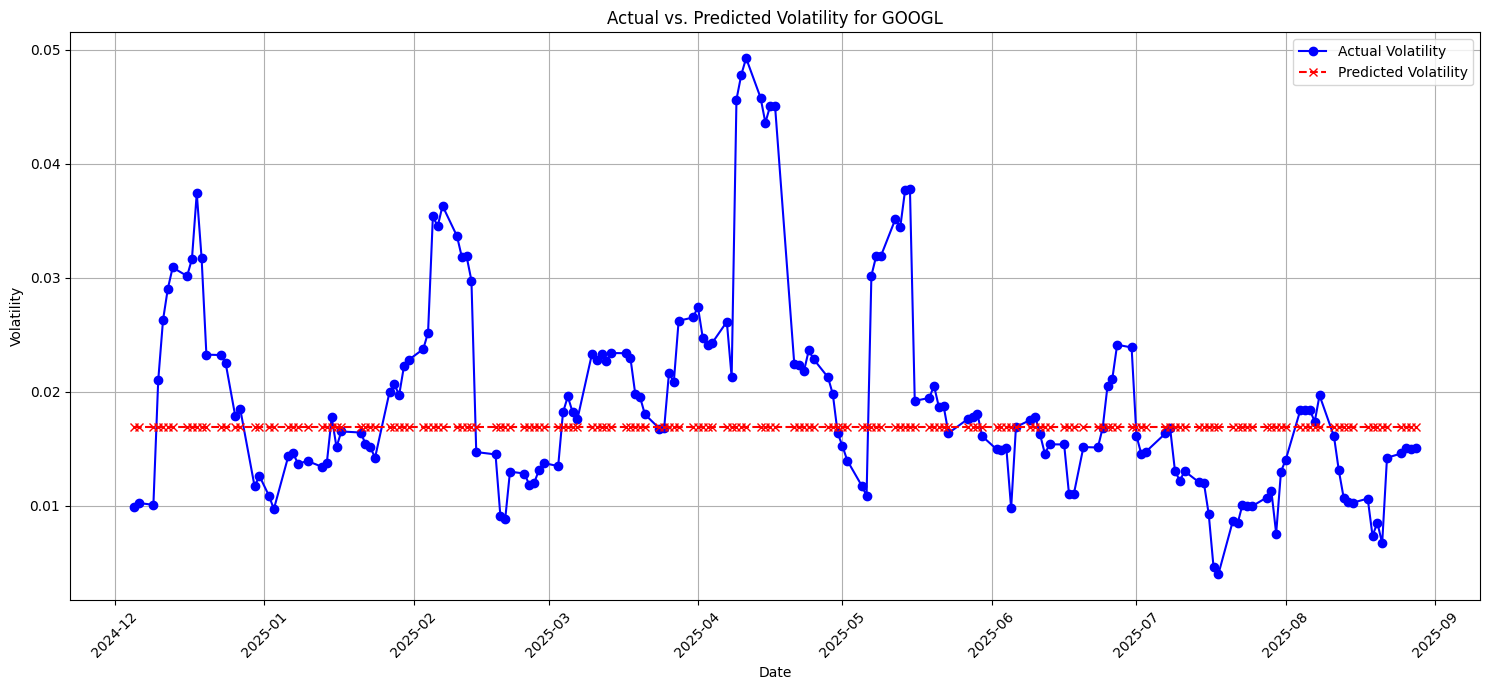


--- Results for MSFT ---
Mean Absolute Error (MAE): 0.007596


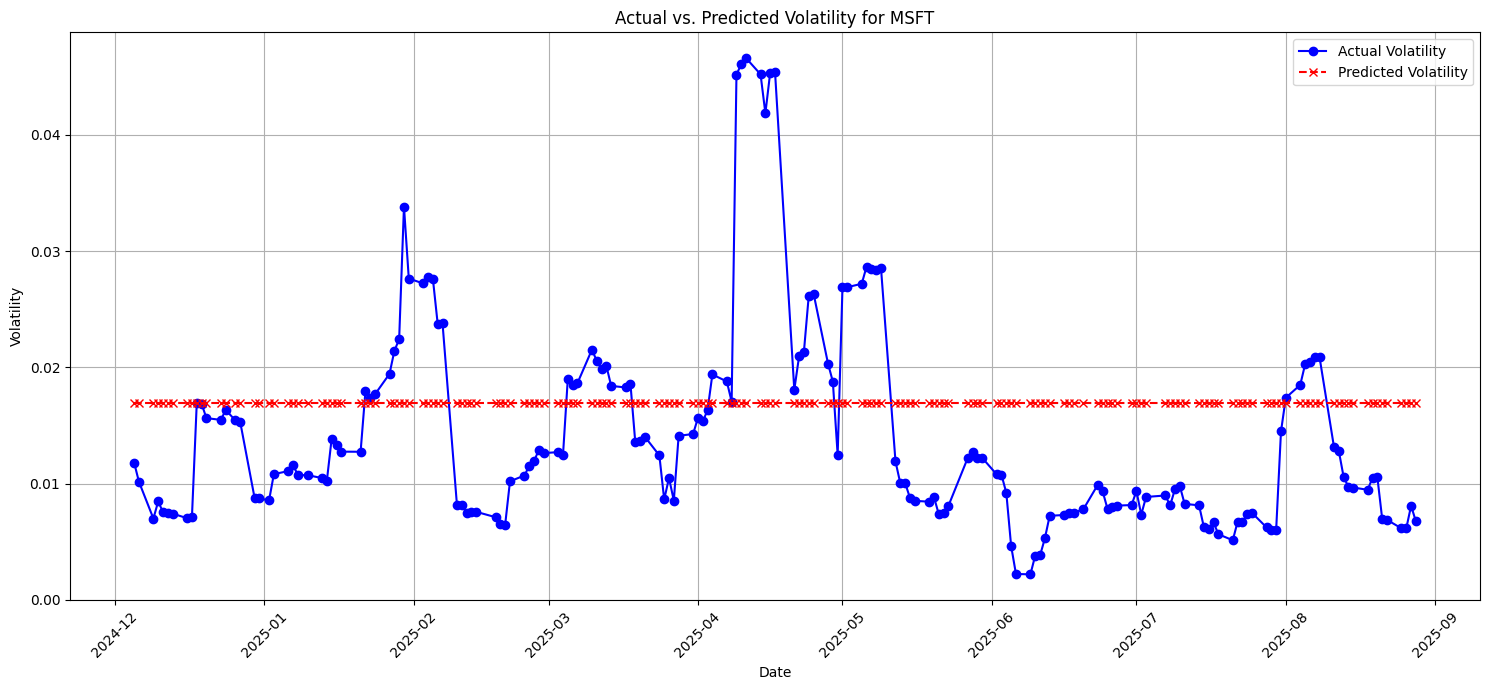


--- Results for AAPL ---
Mean Absolute Error (MAE): 0.008271


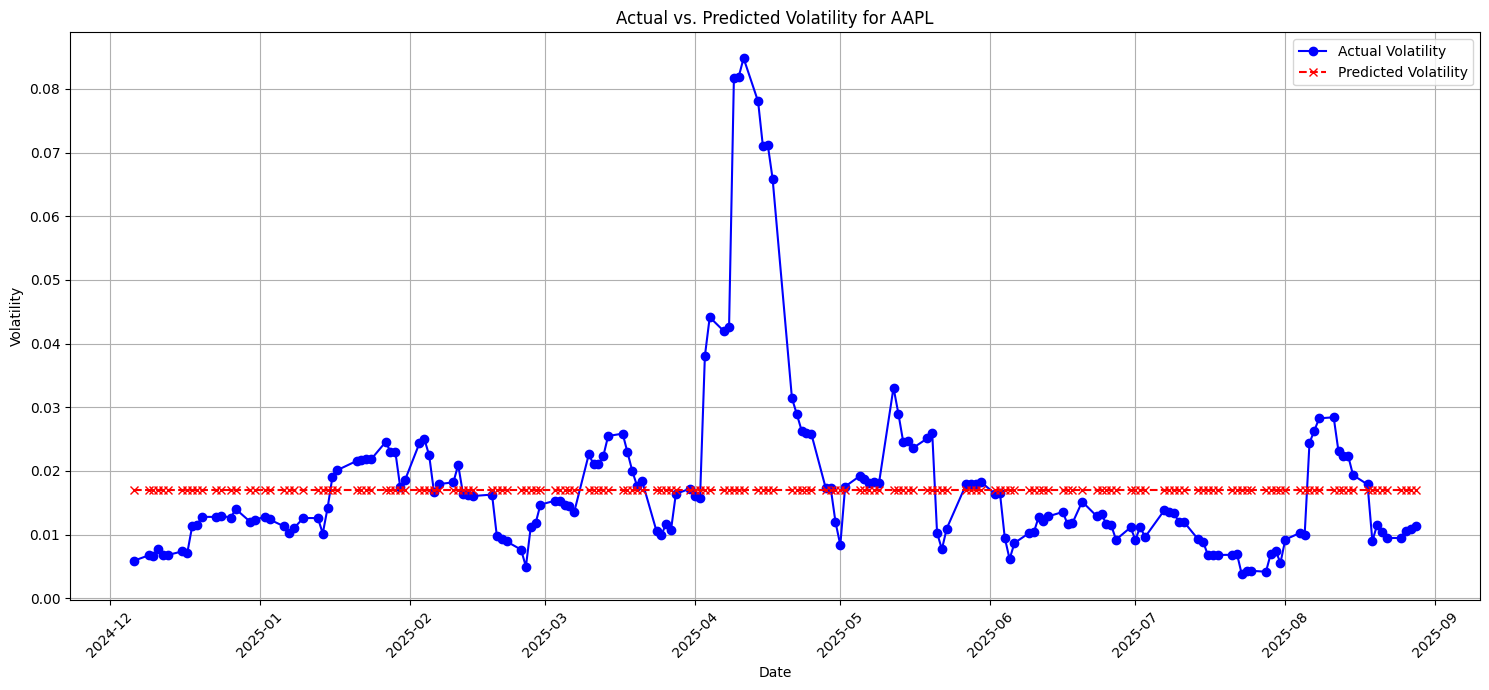

In [ ]:
#--Phase 5: Create lag features, train XGBoost model, evaluate and plot results

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd


print("Creating lag features...")

for i in range(1, 4):
    daily_df[f'mean_sentiment_lag_{i}'] = daily_df.groupby('ticker')['mean_sentiment'].shift(i)
    daily_df[f'sentiment_std_lag_{i}'] = daily_df.groupby('ticker')['sentiment_std'].shift(i)
    daily_df[f'news_volume_lag_{i}'] = daily_df.groupby('ticker')['news_volume'].shift(i)

daily_df = daily_df.dropna()

print("Features created. Preparing data for modeling...")

y = daily_df['volatility']
X = daily_df.drop(columns=['date', 'ticker', 'Close', 'volatility'])

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"Data split into {len(X_train)} training rows and {len(X_test)} testing rows.")

print("Training the XGBoost model...")
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)
model.fit(X_train, y_train)
print("Model training complete.")

print("Making predictions on the test set...")
predictions = model.predict(X_test)


# Evaluate and plot results for each ticker ---

print("\n--- Model Performance Breakdown by Ticker ---")

# First, combine all test data into one DataFrame for easy filtering
results_df = X_test.copy()
results_df['date'] = daily_df.loc[y_test.index, 'date']
results_df['ticker'] = daily_df.loc[y_test.index, 'ticker']
results_df['actual_volatility'] = y_test
results_df['predicted_volatility'] = predictions

# Get the list of unique tickers in our test set
unique_tickers_in_test = results_df['ticker'].unique()

# Loop through each ticker to analyze and plot its results
for ticker in unique_tickers_in_test:
    
    # Filter for current ticker
    ticker_results_df = results_df[results_df['ticker'] == ticker].sort_values('date')
    
    # Calculate the MAE for this specific ticker
    ticker_mae = mean_absolute_error(
        ticker_results_df['actual_volatility'], 
        ticker_results_df['predicted_volatility']
    )
    
    print(f"\n--- Results for {ticker} ---")
    print(f"Mean Absolute Error (MAE): {ticker_mae:.6f}")
    
    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(ticker_results_df['date'], ticker_results_df['actual_volatility'], label='Actual Volatility', color='blue', marker='o')
    plt.plot(ticker_results_df['date'], ticker_results_df['predicted_volatility'], label='Predicted Volatility', color='red', linestyle='--', marker = 'x')
    
    plt.title(f'Actual vs. Predicted Volatility for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show() 

In [22]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'xgboost_volatility_model.joblib')

print("Model saved successfully to 'xgboost_volatility_model.joblib'")

Model saved successfully to 'xgboost_volatility_model.joblib'


In [23]:
# Save the final dataframes needed by the Streamlit app
daily_df.to_csv('final_daily_data.csv', index=False)
master_df.to_csv('all_news_data.csv', index=False)

print("Final data files for the Streamlit app have been saved.")

Final data files for the Streamlit app have been saved.


In [24]:
# --- FINAL STEP: Save all outputs for the Streamlit App ---

import joblib

# Save the final aggregated data used for charts and predictions
daily_df.to_csv('final_daily_data.csv', index=False)

# Save the master dataframe which has all article details
master_df.to_csv('all_news_data.csv', index=False)

# Save the trained model
joblib.dump(model, 'xgboost_volatility_model.joblib')

print("All files for the Streamlit app have been saved successfully!")
print(" - final_daily_data.csv")
print(" - all_news_data.csv")
print(" - xgboost_volatility_model.joblib")

All files for the Streamlit app have been saved successfully!
 - final_daily_data.csv
 - all_news_data.csv
 - xgboost_volatility_model.joblib
